In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
from src.data.datasets import get_dataset
from src.models.networks import get_mlp
from src.utils import one_hot

## Make learning rate plot of schedulers

In [61]:
def make_lr_plot(dfp, var_colors, metrics, names):
    change_points = [14352, 19500, 33240, 38682, 39510]
    n_rows = len(metrics)

    cmapper = ValueColorMapper(values=dfp[var_colors].unique(), cmap="plasma")
    fig, axs = plt.subplots(nrows=n_rows, figsize=(6, 3 * n_rows), sharex=True)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])
    for row_idx, metric in enumerate(metrics):
        ax = axs[row_idx]
        for change_point in change_points:
            ax.axvline(change_point, color="black", linestyle="dashed")
        for schedule, dfs in dfp.groupby(var_colors):
            dfs = dfs.sort_values(by="step")
            color = cmapper(schedule)
            if metric == "accuracy_mean":
                ys = dfs[metric].ewm(alpha=0.25).mean()
            else:
                ys = dfs[metric]
            ax.plot(
                dfs["step"],
                ys,
                c=color,
                label=schedule,
            )

    for ax, name in zip(axs, names):
        ax.set_ylabel(name)
    ax.set_yscale("log", base=2)
    axs[0].legend()
    ax.set_xlabel("Instances")
    return fig

In [57]:
df_sched = pd.read_csv("../reports/schedule/v1.csv.zip")
df_sched = df_sched.fillna(0)
df_sched["schedule"] = df_sched["schedule"].replace(
    {
        "Exponential": "Exp.",
        "Exponential Reset": "Exp. Reset",
        "Exponential Weight Reset": "Exp. Weight Reset",
    }
)
df_sched["accuracy"] *= 100
df_mean = agg_dataframe(df_sched, ["base_lr", "gamma", "max_lr", "dataset", "schedule"])
best_params = get_best_params(
    df_mean,
    params=["base_lr", "gamma", "max_lr"],
    fixed_params=["dataset", "schedule"],
    metric="accuracy_mean",
)
df_sched_best = best_params.merge(
    df_sched, on=["base_lr", "gamma", 'max_lr', "dataset", "schedule"]
)
dfm = agg_dataframe(
    df_sched_best, cols_to_keep=["dataset", "optimizer", "step", "schedule"]
)

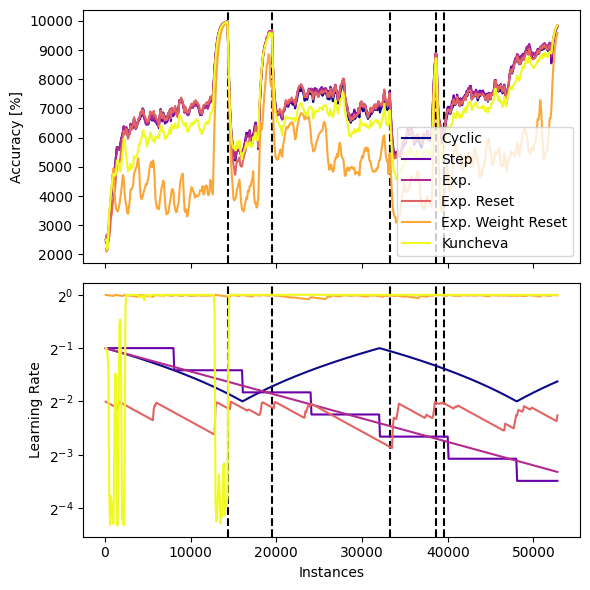

In [58]:
# Make Plot for Insects abrupt dataset
schedules = [
    "Cyclic",
    "Step",
    "Exp.",
    "Exp. Reset",
    "Exp. Weight Reset",
    "Kuncheva",
]
dfp = dfm.copy()
dfp["schedule"] = pd.Categorical(dfp["schedule"], categories=schedules, ordered=True)
# Sort the DataFrame using the custom ordering
dfp = dfp.sort_values(by="schedule")
dfp = dfp[(dfp["dataset"] == "Insects abrupt") & (dfp["schedule"].isin(schedules))]



metrics = ["accuracy_mean", "lr_mean"]
names = ["Accuracy [%]", "Learning Rate"]
fig = make_lr_plot(dfp, "schedule", metrics, names)
fig.tight_layout()
plt.savefig("../pub/figures/lr_norms_schedules_insects_abrupt.pdf")

## Make learning rate plot of adaptive optimizers

In [68]:
df_opt = pd.read_csv("../reports/optimizers/v1.csv.zip")
df_opt = df_opt.fillna(0)

df_opt["optimizer"] = df_opt["optimizer"].replace({"DAdaptSGD": "D-Adapt"})
# Get number of parameters
x, y = get_dataset("Insects abrupt")
y = one_hot(y)
x_sample, y_sample = x[0], y[0]
net = get_mlp(x_sample.shape[-1], y_sample.shape[-1])
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
# Adjust LR for number of parameters
# df_opt.loc[:, 'lr_norm'] /= np.sqrt(n_params)
df_opt["accuracy"] *= 100

df_mean = agg_dataframe(df_opt, ["base_lr", "dataset", "optimizer"])
best_params = get_best_params(
    df_mean,
    params=["base_lr"],
    fixed_params=["dataset", "optimizer"],
    metric="accuracy_mean",
)
df_opt_best = best_params.merge(df_opt, on=["base_lr", "dataset", "optimizer"])
dfm = agg_dataframe(
    df_opt_best, cols_to_keep=["dataset", "optimizer", "step"]
)

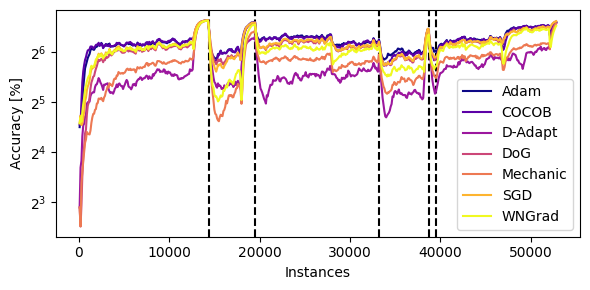

In [69]:
# Make Plot for Insects abrupt dataset
optimizers = [
    "SGD",
    "Adam",
    "COCOB",
    "WNGrad",
    "D-Adapt",
    "DoG",
    "Mechanic",
]
dfp = dfm.copy()
dfp["schedule"] = pd.Categorical(dfp["optimizer"], categories=optimizers, ordered=True)
# Sort the DataFrame using the custom ordering
dfp = dfp.sort_values(by="optimizer")
dfp = dfp[(dfp["dataset"] == "Insects abrupt") & (dfp["optimizer"].isin(optimizers))]

metrics = ["accuracy_mean", "lr_norm_mean"]
names = ["Accuracy [%]", "Learning Rate"]
fig = make_lr_plot(dfp, "optimizer", metrics, names)
fig.tight_layout()
plt.savefig("../pub/figures/lr_norms_optims_insects_abrupt.pdf")
